<img style="float: right;" width="120" src="../Images/supplier-logo.png">
<img style="float: left; margin-top: 0" width="80" src="../Images/client-logo.png">
<br><br><br>

# Federal Reserve Bank of St Louis

https://fred.stlouisfed.org/

This site makes its own economic and financial datasets available as spreadsheets, csv files and pandas DataFrames.

DataFrames are imported into notebooks using the pandas_datareader package, a widely used package to give remote data access directly from a web site.

This notebook shows how to import disparate datasets from this web site, perform some analysis and produce some heatmaps of this data.

The datasets being uses are the 
- consumer price index
- federal funds rate


## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# We need the pandas datareader and datetime packaged
import pandas_datareader as pdr
import datetime


## Import the data

Use the data reader to import the FRED Datasets we need and specify the date range

Quickly inspect the Datframe, execute head, describe etc

Also plot a few graphs

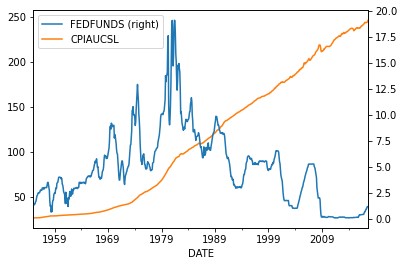

In [2]:
start = datetime.datetime(1955, 1, 1)
end = datetime.datetime(2017, 9, 1)

reader = pdr.fred.FredReader(["FEDFUNDS","CPIAUCSL"],start,end)

df = reader.read()

df.plot(kind="line", secondary_y = 'FEDFUNDS')

plt.show()

## Transform the data

These 2 datasets are not comparable, one is an interest rate, the other  a measure of prices (hence always increasing). In such circumstances, its often the case that the user will transform one or both data sets into something else to aid further analysis. 

In this case, use the `pct_change()` to calculate the %age change of the CPI Index.

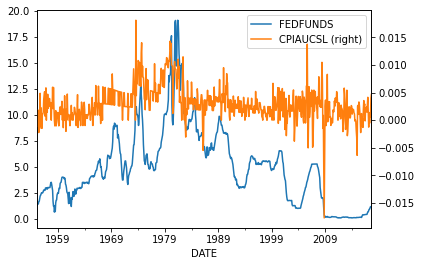

In [3]:
df["CPIAUCSL"] = df["CPIAUCSL"].pct_change()

df.plot(kind="line", secondary_y = 'CPIAUCSL')

df.dropna(inplace=True)

plt.show()

A hexbin plot from these two series.

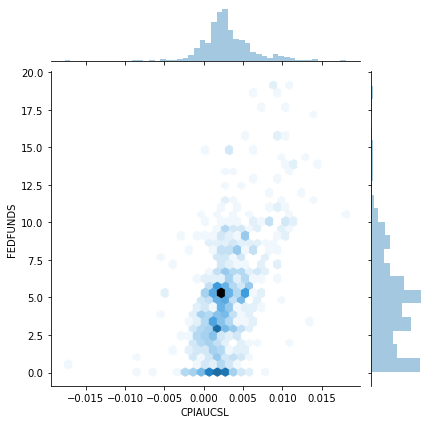

In [4]:
import seaborn as sns
sns.jointplot(df["CPIAUCSL"],df["FEDFUNDS"],kind="hex")
plt.show()

## Creating a heatmap

### 1) Create percentiles for each dataset

Before creating the heatmap its often necessary to perform some preparatory groundwork. 

Here we are going to create 10 groups for each data series representing the ten deciles.

Using pandas `rank()` function we can easily get the percentiles and write a simple function to convert a percentile to a group between 1 and 10.

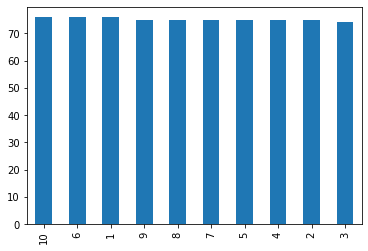

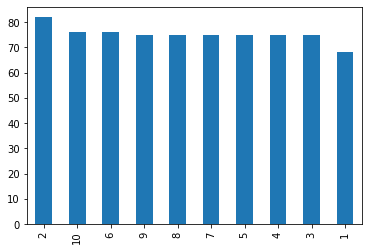

In [5]:
#  convert a percentile to a category between 1 and 10
def decile(x):
    x = int(x*10)+1
    if x==11:
        x=10
    return x

rankings = df.rank(pct=True).applymap(decile)

# Perform a quick plot to check that all is well
rankings["FEDFUNDS"].value_counts().plot(kind="bar")
plt.show()
rankings["CPIAUCSL"].value_counts().plot(kind="bar")
plt.show()

### 2)	Pivot the Data

Use the `pivot()` functionality in pandas to pivot the dataset. 

In this case set the index to be the FEDFUNDS dataset and the columns to be the CPI Index and then count how many records are at each intersection.

Use `len` as the aggregate function to count the records at each intersection.


In [ ]:
pivot = rankings.pivot_table(index='FEDFUNDS', columns='CPIAUCSL', aggfunc=len)

pivot

### 3) Produce the first heatmap

There are a few variations here

- Use the defaults
- annotate the heatmap
- Invert the axis

In [ ]:
sns.heatmap(pivot)
plt.show()

sns.heatmap(pivot, annot=True)
plt.show()

ax = sns.heatmap(pivot, annot=True)
ax.invert_yaxis()
plt.show()

## Perform some correlations

Using Fred, load in some more economic data and produce a correlation matrix to see if any of these items are strongly correlated.

### 1) Load in the data

Note in the following code I have renamed the columns to something more understandable.


In [ ]:
df = pdr.fred.FredReader(["FEDFUNDS","CPIAUCSL","AAA","UNRATE","GS5","MSACSR","PCE","M2NS"],start,end).read()

df["CPIAUCSL"] = df["CPIAUCSL"].pct_change()
df["PCE"] = df["PCE"].pct_change()
df["M2NS"] = df["M2NS"].pct_change()
df.dropna(inplace=True)

df.columns = ["Fed Funds","CPI Change","AAA Yield","Unemployment","5 Year Treasury","Housing Supply","Consumption Change","M2 Money Change"]
df

### 2) Correlate

In [ ]:
corr = df.corr()
corr

### 3) Show the resulting heatmap

In [ ]:
sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
sns.heatmap(corr,annot=True)
plt.show()

## Advanced

This part of the notebook is very advanced but is included to show the reader how sophisticated analysis can be performed with relatively little code.

In the correlation matrix above, data is duplicated.

It is possible to create a mask to hide the top right had trianle of correlation data.


### 1) Create a 2D masking array 

With the same dimensions as the correlation matrix

In [ ]:
mask = np.zeros(corr.shape, dtype=bool)
mask

### 2) Get triangle Upper Indices

In [ ]:
mask[np.triu_indices(len(mask))] = True
mask

### 3) Mask out the upper part of the heat map

In [ ]:
sns.heatmap(corr,annot=True,mask=mask)
plt.show()